# Segmentation map으로 도로 이미지 만들기
-----------------

* 프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고   
Tensorflow Pix2Pix Tutorial

## 프로젝트 수행

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

### 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

#### 데이터 준비하기

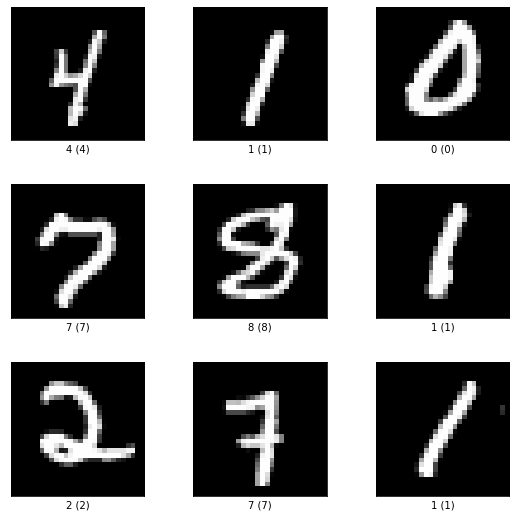

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


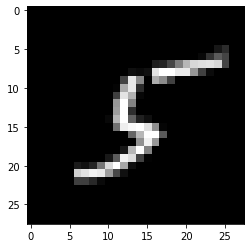

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

#### GAN Generator 구성하기

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


#### cGAN Generator 구성하기

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


#### GAN Discriminator 구성하기

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


#### cGAN Discriminator 구성하기

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


#### GAN으로 MNIST 학습하기

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.072722911834717, D:0.14692151546478271
[1/10 EPOCHS, 200 ITER] G:2.328920841217041, D:0.13463693857192993
[1/10 EPOCHS, 300 ITER] G:2.485907793045044, D:0.11169742792844772
[1/10 EPOCHS, 400 ITER] G:3.6975247859954834, D:0.07860150933265686
[2/10 EPOCHS, 100 ITER] G:2.6171584129333496, D:0.1623808592557907
[2/10 EPOCHS, 200 ITER] G:3.1733899116516113, D:0.14419396221637726
[2/10 EPOCHS, 300 ITER] G:3.8630309104919434, D:0.20180213451385498
[2/10 EPOCHS, 400 ITER] G:2.9949872493743896, D:0.14851774275302887
[3/10 EPOCHS, 100 ITER] G:2.7217373847961426, D:0.1828257441520691
[3/10 EPOCHS, 200 ITER] G:2.943946599960327, D:0.2142745852470398
[3/10 EPOCHS, 300 ITER] G:3.7177574634552, D:0.1254889816045761
[3/10 EPOCHS, 400 ITER] G:3.8174889087677, D:0.18189474940299988
[4/10 EPOCHS, 100 ITER] G:5.172373294830322, D:0.015628153458237648
[4/10 EPOCHS, 200 ITER] G:3.740342140197754, D:0.10926254093647003
[4/10 EPOCHS, 300 ITER] G:2.591310739517212, D:0.25829583406448

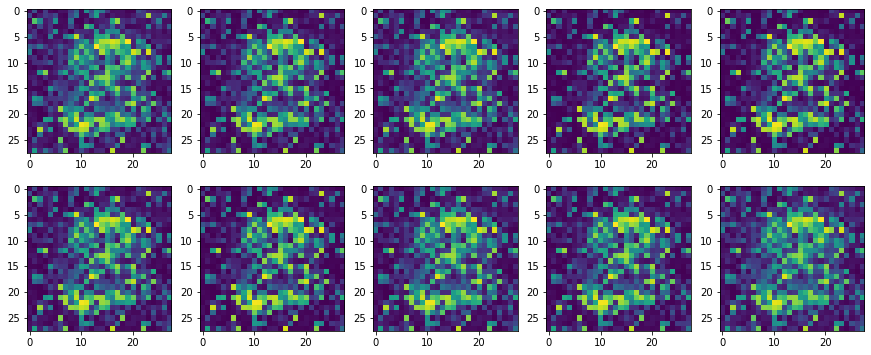

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [13]:
EPOCHS = 500
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/500 EPOCHS, 100 ITER] G:4.8812055587768555, D:0.029937420040369034
[1/500 EPOCHS, 200 ITER] G:4.369440078735352, D:0.18809038400650024
[1/500 EPOCHS, 300 ITER] G:4.081935882568359, D:0.054300881922245026
[1/500 EPOCHS, 400 ITER] G:4.987005233764648, D:0.022732287645339966
[2/500 EPOCHS, 100 ITER] G:3.3284413814544678, D:0.1723889708518982
[2/500 EPOCHS, 200 ITER] G:5.9665727615356445, D:0.07318947464227676
[2/500 EPOCHS, 300 ITER] G:4.535696029663086, D:0.023737600073218346
[2/500 EPOCHS, 400 ITER] G:4.801664352416992, D:0.04529183357954025
[3/500 EPOCHS, 100 ITER] G:3.6235530376434326, D:0.1424831598997116
[3/500 EPOCHS, 200 ITER] G:3.8900983333587646, D:0.04928334802389145
[3/500 EPOCHS, 300 ITER] G:4.453692436218262, D:0.021883975714445114
[3/500 EPOCHS, 400 ITER] G:5.074146270751953, D:0.009564315900206566
[4/500 EPOCHS, 100 ITER] G:5.219721794128418, D:0.1180773600935936
[4/500 EPOCHS, 200 ITER] G:8.309981346130371, D:0.07072707265615463
[4/500 EPOCHS, 300 ITER] G:6.71537637710

[30/500 EPOCHS, 400 ITER] G:9.892654418945312, D:0.00011707697558449581
[31/500 EPOCHS, 100 ITER] G:9.219880104064941, D:0.007035418413579464
[31/500 EPOCHS, 200 ITER] G:16.26081085205078, D:0.07561734318733215
[31/500 EPOCHS, 300 ITER] G:5.995867729187012, D:0.22224755585193634
[31/500 EPOCHS, 400 ITER] G:8.295766830444336, D:0.022042954340577126
[32/500 EPOCHS, 100 ITER] G:11.162200927734375, D:0.0009010476060211658
[32/500 EPOCHS, 200 ITER] G:5.341413974761963, D:0.06102725863456726
[32/500 EPOCHS, 300 ITER] G:6.754699230194092, D:0.005408410914242268
[32/500 EPOCHS, 400 ITER] G:8.871508598327637, D:0.040823355317115784
[33/500 EPOCHS, 100 ITER] G:16.82927894592285, D:0.1453397125005722
[33/500 EPOCHS, 200 ITER] G:4.839363098144531, D:0.017187466844916344
[33/500 EPOCHS, 300 ITER] G:4.149131774902344, D:0.05510486662387848
[33/500 EPOCHS, 400 ITER] G:4.955731391906738, D:0.04631951451301575
[34/500 EPOCHS, 100 ITER] G:7.5654473304748535, D:0.06334561109542847
[34/500 EPOCHS, 200 ITE

[60/500 EPOCHS, 300 ITER] G:4.773714065551758, D:0.06368470191955566
[60/500 EPOCHS, 400 ITER] G:5.0023417472839355, D:0.2261514812707901
[61/500 EPOCHS, 100 ITER] G:5.91019868850708, D:0.6142758131027222
[61/500 EPOCHS, 200 ITER] G:6.114031791687012, D:0.37406840920448303
[61/500 EPOCHS, 300 ITER] G:3.4626822471618652, D:0.26097962260246277
[61/500 EPOCHS, 400 ITER] G:4.300899028778076, D:0.22046440839767456
[62/500 EPOCHS, 100 ITER] G:4.684610843658447, D:0.2942630350589752
[62/500 EPOCHS, 200 ITER] G:3.4689011573791504, D:0.20203576982021332
[62/500 EPOCHS, 300 ITER] G:4.0959086418151855, D:0.2156832218170166
[62/500 EPOCHS, 400 ITER] G:3.2599592208862305, D:0.25042814016342163
[63/500 EPOCHS, 100 ITER] G:3.0331716537475586, D:0.27329736948013306
[63/500 EPOCHS, 200 ITER] G:3.471128463745117, D:0.29854458570480347
[63/500 EPOCHS, 300 ITER] G:4.774135112762451, D:0.1849161982536316
[63/500 EPOCHS, 400 ITER] G:4.787788391113281, D:0.4789433181285858
[64/500 EPOCHS, 100 ITER] G:3.03406

[90/500 EPOCHS, 300 ITER] G:2.9648184776306152, D:0.6939452886581421
[90/500 EPOCHS, 400 ITER] G:2.560767650604248, D:0.4739348888397217
[91/500 EPOCHS, 100 ITER] G:2.2288918495178223, D:0.4243057668209076
[91/500 EPOCHS, 200 ITER] G:2.140645980834961, D:0.5021937489509583
[91/500 EPOCHS, 300 ITER] G:1.962839126586914, D:0.567647397518158
[91/500 EPOCHS, 400 ITER] G:2.374464511871338, D:0.515570878982544
[92/500 EPOCHS, 100 ITER] G:2.326552152633667, D:0.502282440662384
[92/500 EPOCHS, 200 ITER] G:2.1802620887756348, D:0.5549518465995789
[92/500 EPOCHS, 300 ITER] G:2.4245152473449707, D:0.5556575059890747
[92/500 EPOCHS, 400 ITER] G:2.74391508102417, D:0.607371985912323
[93/500 EPOCHS, 100 ITER] G:3.0061209201812744, D:0.6555690765380859
[93/500 EPOCHS, 200 ITER] G:2.044236898422241, D:0.5644915699958801
[93/500 EPOCHS, 300 ITER] G:2.9294211864471436, D:0.48331883549690247
[93/500 EPOCHS, 400 ITER] G:2.8277266025543213, D:0.3892004191875458
[94/500 EPOCHS, 100 ITER] G:2.484657287597656

[120/500 EPOCHS, 200 ITER] G:1.5465911626815796, D:0.6602466702461243
[120/500 EPOCHS, 300 ITER] G:1.880643606185913, D:0.6027317047119141
[120/500 EPOCHS, 400 ITER] G:1.840234637260437, D:0.5898951292037964
[121/500 EPOCHS, 100 ITER] G:1.8432197570800781, D:0.7034654021263123
[121/500 EPOCHS, 200 ITER] G:1.810409665107727, D:0.7037752270698547
[121/500 EPOCHS, 300 ITER] G:2.197666645050049, D:0.773240327835083
[121/500 EPOCHS, 400 ITER] G:2.1060900688171387, D:0.6050090789794922
[122/500 EPOCHS, 100 ITER] G:2.450075387954712, D:0.6167019009590149
[122/500 EPOCHS, 200 ITER] G:2.118873357772827, D:0.7263452410697937
[122/500 EPOCHS, 300 ITER] G:2.0357508659362793, D:0.6107625961303711
[122/500 EPOCHS, 400 ITER] G:1.929178237915039, D:0.6801177263259888
[123/500 EPOCHS, 100 ITER] G:1.7038938999176025, D:0.6185078024864197
[123/500 EPOCHS, 200 ITER] G:2.202988862991333, D:0.6422562599182129
[123/500 EPOCHS, 300 ITER] G:2.2235424518585205, D:0.6219228506088257
[123/500 EPOCHS, 400 ITER] G:

[149/500 EPOCHS, 400 ITER] G:1.717207670211792, D:0.6488028764724731
[150/500 EPOCHS, 100 ITER] G:1.859562635421753, D:0.7713028192520142
[150/500 EPOCHS, 200 ITER] G:1.8576550483703613, D:0.6456142663955688
[150/500 EPOCHS, 300 ITER] G:1.701770305633545, D:0.6376237869262695
[150/500 EPOCHS, 400 ITER] G:2.1261587142944336, D:0.7511928081512451
[151/500 EPOCHS, 100 ITER] G:1.6363475322723389, D:0.8181655406951904
[151/500 EPOCHS, 200 ITER] G:1.894139051437378, D:0.7133020162582397
[151/500 EPOCHS, 300 ITER] G:1.6421830654144287, D:0.7276666760444641
[151/500 EPOCHS, 400 ITER] G:1.8503539562225342, D:0.7959200739860535
[152/500 EPOCHS, 100 ITER] G:1.756579875946045, D:0.7648780345916748
[152/500 EPOCHS, 200 ITER] G:1.828200340270996, D:0.7871137857437134
[152/500 EPOCHS, 300 ITER] G:2.0946266651153564, D:0.5332531929016113
[152/500 EPOCHS, 400 ITER] G:2.0301623344421387, D:0.831586480140686
[153/500 EPOCHS, 100 ITER] G:1.6613221168518066, D:0.6851893663406372
[153/500 EPOCHS, 200 ITER] 

[179/500 EPOCHS, 200 ITER] G:1.9418787956237793, D:0.657473087310791
[179/500 EPOCHS, 300 ITER] G:1.785496473312378, D:0.6323478817939758
[179/500 EPOCHS, 400 ITER] G:1.6879686117172241, D:0.7069711685180664
[180/500 EPOCHS, 100 ITER] G:1.918731927871704, D:0.6855660676956177
[180/500 EPOCHS, 200 ITER] G:2.0296428203582764, D:0.6415017247200012
[180/500 EPOCHS, 300 ITER] G:2.100782871246338, D:0.6892436146736145
[180/500 EPOCHS, 400 ITER] G:2.0321743488311768, D:0.8810935020446777
[181/500 EPOCHS, 100 ITER] G:1.9937493801116943, D:0.7943460941314697
[181/500 EPOCHS, 200 ITER] G:2.21673583984375, D:0.6506481766700745
[181/500 EPOCHS, 300 ITER] G:1.775601863861084, D:0.6511486768722534
[181/500 EPOCHS, 400 ITER] G:1.6156737804412842, D:0.6961960792541504
[182/500 EPOCHS, 100 ITER] G:1.8320034742355347, D:0.6623432636260986
[182/500 EPOCHS, 200 ITER] G:1.808665156364441, D:0.7424099445343018
[182/500 EPOCHS, 300 ITER] G:2.198239803314209, D:0.5642366409301758
[182/500 EPOCHS, 400 ITER] G:

[208/500 EPOCHS, 400 ITER] G:1.8178520202636719, D:0.8448666334152222
[209/500 EPOCHS, 100 ITER] G:1.989180088043213, D:0.5910338759422302
[209/500 EPOCHS, 200 ITER] G:2.1092684268951416, D:0.6524272561073303
[209/500 EPOCHS, 300 ITER] G:1.5070841312408447, D:0.5418728590011597
[209/500 EPOCHS, 400 ITER] G:1.7566447257995605, D:0.727263331413269
[210/500 EPOCHS, 100 ITER] G:1.9529697895050049, D:0.5533665418624878
[210/500 EPOCHS, 200 ITER] G:2.108464241027832, D:0.6796948909759521
[210/500 EPOCHS, 300 ITER] G:2.091386079788208, D:0.7564266324043274
[210/500 EPOCHS, 400 ITER] G:1.4646003246307373, D:0.7798837423324585
[211/500 EPOCHS, 100 ITER] G:1.802065372467041, D:0.7821924686431885
[211/500 EPOCHS, 200 ITER] G:1.6432721614837646, D:0.8267679214477539
[211/500 EPOCHS, 300 ITER] G:1.6611640453338623, D:0.7219825387001038
[211/500 EPOCHS, 400 ITER] G:1.6188995838165283, D:0.6277199983596802
[212/500 EPOCHS, 100 ITER] G:2.1012258529663086, D:0.6939437389373779
[212/500 EPOCHS, 200 ITER

[238/500 EPOCHS, 200 ITER] G:1.6243703365325928, D:0.7586343288421631
[238/500 EPOCHS, 300 ITER] G:1.7621017694473267, D:0.6559247970581055
[238/500 EPOCHS, 400 ITER] G:1.7939635515213013, D:0.7237955331802368
[239/500 EPOCHS, 100 ITER] G:1.59189772605896, D:0.774733304977417
[239/500 EPOCHS, 200 ITER] G:1.9953114986419678, D:0.697256326675415
[239/500 EPOCHS, 300 ITER] G:1.9413671493530273, D:0.598425030708313
[239/500 EPOCHS, 400 ITER] G:1.895117998123169, D:0.6381131410598755
[240/500 EPOCHS, 100 ITER] G:1.5859225988388062, D:0.6277046799659729
[240/500 EPOCHS, 200 ITER] G:1.783156156539917, D:0.7385483980178833
[240/500 EPOCHS, 300 ITER] G:1.8963171243667603, D:0.6672998666763306
[240/500 EPOCHS, 400 ITER] G:1.5499773025512695, D:0.7309092879295349
[241/500 EPOCHS, 100 ITER] G:1.5929416418075562, D:0.6909608244895935
[241/500 EPOCHS, 200 ITER] G:1.8630244731903076, D:0.5811348557472229
[241/500 EPOCHS, 300 ITER] G:1.7811858654022217, D:0.5866950750350952
[241/500 EPOCHS, 400 ITER] 

[267/500 EPOCHS, 400 ITER] G:1.9475860595703125, D:0.6324643492698669
[268/500 EPOCHS, 100 ITER] G:1.6605136394500732, D:0.5955486297607422
[268/500 EPOCHS, 200 ITER] G:1.7144007682800293, D:0.5347751379013062
[268/500 EPOCHS, 300 ITER] G:1.990128993988037, D:0.7516001462936401
[268/500 EPOCHS, 400 ITER] G:1.5274643898010254, D:0.8645582795143127
[269/500 EPOCHS, 100 ITER] G:1.9449517726898193, D:0.6327753067016602
[269/500 EPOCHS, 200 ITER] G:1.8998165130615234, D:0.5579911470413208
[269/500 EPOCHS, 300 ITER] G:1.9984079599380493, D:0.6251816153526306
[269/500 EPOCHS, 400 ITER] G:1.6982760429382324, D:0.6264345645904541
[270/500 EPOCHS, 100 ITER] G:1.7185568809509277, D:0.7431688904762268
[270/500 EPOCHS, 200 ITER] G:1.9996943473815918, D:0.689880907535553
[270/500 EPOCHS, 300 ITER] G:1.80972158908844, D:0.6657012701034546
[270/500 EPOCHS, 400 ITER] G:1.6942023038864136, D:0.6899203658103943
[271/500 EPOCHS, 100 ITER] G:2.1549601554870605, D:0.7267411947250366
[271/500 EPOCHS, 200 ITE

[297/500 EPOCHS, 200 ITER] G:1.8626785278320312, D:0.612135648727417
[297/500 EPOCHS, 300 ITER] G:1.9473692178726196, D:0.47216007113456726
[297/500 EPOCHS, 400 ITER] G:1.6905207633972168, D:0.6106504201889038
[298/500 EPOCHS, 100 ITER] G:1.935518503189087, D:0.712544322013855
[298/500 EPOCHS, 200 ITER] G:1.7471240758895874, D:0.6309871673583984
[298/500 EPOCHS, 300 ITER] G:1.8029999732971191, D:0.6317225694656372
[298/500 EPOCHS, 400 ITER] G:2.065950870513916, D:0.5538961887359619
[299/500 EPOCHS, 100 ITER] G:2.3264925479888916, D:0.5988773703575134
[299/500 EPOCHS, 200 ITER] G:1.9078892469406128, D:0.5756369829177856
[299/500 EPOCHS, 300 ITER] G:2.013345241546631, D:0.671143651008606
[299/500 EPOCHS, 400 ITER] G:2.3077051639556885, D:0.67662113904953
[300/500 EPOCHS, 100 ITER] G:2.0733630657196045, D:0.7020695805549622
[300/500 EPOCHS, 200 ITER] G:1.83188796043396, D:0.5858665704727173
[300/500 EPOCHS, 300 ITER] G:1.802164077758789, D:0.603996753692627
[300/500 EPOCHS, 400 ITER] G:2.

[326/500 EPOCHS, 400 ITER] G:1.7825605869293213, D:0.697670578956604
[327/500 EPOCHS, 100 ITER] G:2.44793438911438, D:0.6075941324234009
[327/500 EPOCHS, 200 ITER] G:1.919069528579712, D:0.6182932257652283
[327/500 EPOCHS, 300 ITER] G:2.0443782806396484, D:0.6073957681655884
[327/500 EPOCHS, 400 ITER] G:2.3346638679504395, D:0.6039732694625854
[328/500 EPOCHS, 100 ITER] G:1.7759404182434082, D:0.7481953501701355
[328/500 EPOCHS, 200 ITER] G:2.125854969024658, D:0.6483544111251831
[328/500 EPOCHS, 300 ITER] G:1.921606183052063, D:0.5952885150909424
[328/500 EPOCHS, 400 ITER] G:1.798943042755127, D:0.6310391426086426
[329/500 EPOCHS, 100 ITER] G:1.5401952266693115, D:0.7875891923904419
[329/500 EPOCHS, 200 ITER] G:1.985740065574646, D:0.5436713099479675
[329/500 EPOCHS, 300 ITER] G:2.066135883331299, D:0.5599468350410461
[329/500 EPOCHS, 400 ITER] G:2.2330245971679688, D:0.636599063873291
[330/500 EPOCHS, 100 ITER] G:2.1919150352478027, D:0.5563342571258545
[330/500 EPOCHS, 200 ITER] G:2

[356/500 EPOCHS, 200 ITER] G:2.0265073776245117, D:0.5628461837768555
[356/500 EPOCHS, 300 ITER] G:2.4183506965637207, D:0.5715771913528442
[356/500 EPOCHS, 400 ITER] G:2.180391788482666, D:0.51371169090271
[357/500 EPOCHS, 100 ITER] G:1.8813663721084595, D:0.5257307291030884
[357/500 EPOCHS, 200 ITER] G:2.0577666759490967, D:0.5584613680839539
[357/500 EPOCHS, 300 ITER] G:2.1420738697052, D:0.5983337163925171
[357/500 EPOCHS, 400 ITER] G:2.075110912322998, D:0.5803288221359253
[358/500 EPOCHS, 100 ITER] G:2.582821846008301, D:0.5883306264877319
[358/500 EPOCHS, 200 ITER] G:2.089484453201294, D:0.555182695388794
[358/500 EPOCHS, 300 ITER] G:1.7719247341156006, D:0.4759347438812256
[358/500 EPOCHS, 400 ITER] G:2.1907389163970947, D:0.4586419463157654
[359/500 EPOCHS, 100 ITER] G:2.197368860244751, D:0.6444778442382812
[359/500 EPOCHS, 200 ITER] G:1.6238594055175781, D:0.5546450614929199
[359/500 EPOCHS, 300 ITER] G:2.03362774848938, D:0.6552102565765381
[359/500 EPOCHS, 400 ITER] G:2.07

[385/500 EPOCHS, 400 ITER] G:2.110215187072754, D:0.48682063817977905
[386/500 EPOCHS, 100 ITER] G:2.7200422286987305, D:0.5274725556373596
[386/500 EPOCHS, 200 ITER] G:2.062722682952881, D:0.5860249996185303
[386/500 EPOCHS, 300 ITER] G:2.2571141719818115, D:0.4861382842063904
[386/500 EPOCHS, 400 ITER] G:2.186049222946167, D:0.4870365262031555
[387/500 EPOCHS, 100 ITER] G:2.313795566558838, D:0.44338977336883545
[387/500 EPOCHS, 200 ITER] G:1.827879548072815, D:0.5881032943725586
[387/500 EPOCHS, 300 ITER] G:1.9750711917877197, D:0.5183094143867493
[387/500 EPOCHS, 400 ITER] G:2.040066719055176, D:0.5223445892333984
[388/500 EPOCHS, 100 ITER] G:2.3964953422546387, D:0.487967312335968
[388/500 EPOCHS, 200 ITER] G:2.346513271331787, D:0.499120831489563
[388/500 EPOCHS, 300 ITER] G:2.152845621109009, D:0.519193708896637
[388/500 EPOCHS, 400 ITER] G:2.1840248107910156, D:0.4791381359100342
[389/500 EPOCHS, 100 ITER] G:2.213003635406494, D:0.4953177571296692
[389/500 EPOCHS, 200 ITER] G:1

[415/500 EPOCHS, 200 ITER] G:2.864123582839966, D:0.48505622148513794
[415/500 EPOCHS, 300 ITER] G:2.4136669635772705, D:0.4714864492416382
[415/500 EPOCHS, 400 ITER] G:2.1518454551696777, D:0.537455677986145
[416/500 EPOCHS, 100 ITER] G:2.250293731689453, D:0.48561275005340576
[416/500 EPOCHS, 200 ITER] G:2.2814993858337402, D:0.4932759404182434
[416/500 EPOCHS, 300 ITER] G:2.2317557334899902, D:0.47803795337677
[416/500 EPOCHS, 400 ITER] G:2.3038482666015625, D:0.5372570157051086
[417/500 EPOCHS, 100 ITER] G:2.341585397720337, D:0.43966126441955566
[417/500 EPOCHS, 200 ITER] G:2.2237353324890137, D:0.5441174507141113
[417/500 EPOCHS, 300 ITER] G:2.159377098083496, D:0.41030746698379517
[417/500 EPOCHS, 400 ITER] G:2.1830615997314453, D:0.4963865280151367
[418/500 EPOCHS, 100 ITER] G:2.325967788696289, D:0.47500404715538025
[418/500 EPOCHS, 200 ITER] G:2.3449299335479736, D:0.6270052790641785
[418/500 EPOCHS, 300 ITER] G:2.3061397075653076, D:0.48599591851234436
[418/500 EPOCHS, 400 I

[444/500 EPOCHS, 400 ITER] G:2.2946290969848633, D:0.5031033754348755
[445/500 EPOCHS, 100 ITER] G:2.179234504699707, D:0.4853382706642151
[445/500 EPOCHS, 200 ITER] G:2.4855096340179443, D:0.4863470196723938
[445/500 EPOCHS, 300 ITER] G:2.6364188194274902, D:0.4867303669452667
[445/500 EPOCHS, 400 ITER] G:2.0864086151123047, D:0.42159873247146606
[446/500 EPOCHS, 100 ITER] G:2.3880021572113037, D:0.4401240944862366
[446/500 EPOCHS, 200 ITER] G:2.517822265625, D:0.46941736340522766
[446/500 EPOCHS, 300 ITER] G:2.0652735233306885, D:0.4273127019405365
[446/500 EPOCHS, 400 ITER] G:2.229855537414551, D:0.5016257762908936
[447/500 EPOCHS, 100 ITER] G:2.5115246772766113, D:0.48240363597869873
[447/500 EPOCHS, 200 ITER] G:2.3516485691070557, D:0.502978503704071
[447/500 EPOCHS, 300 ITER] G:2.2816901206970215, D:0.4276120066642761
[447/500 EPOCHS, 400 ITER] G:2.4944357872009277, D:0.4598720669746399
[448/500 EPOCHS, 100 ITER] G:2.3216872215270996, D:0.597801148891449
[448/500 EPOCHS, 200 ITER

[474/500 EPOCHS, 200 ITER] G:2.299436092376709, D:0.5628798007965088
[474/500 EPOCHS, 300 ITER] G:2.254526376724243, D:0.3942378759384155
[474/500 EPOCHS, 400 ITER] G:2.274315595626831, D:0.5334880352020264
[475/500 EPOCHS, 100 ITER] G:2.6603591442108154, D:0.5378426313400269
[475/500 EPOCHS, 200 ITER] G:2.2315640449523926, D:0.30382150411605835
[475/500 EPOCHS, 300 ITER] G:2.4316649436950684, D:0.29835331439971924
[475/500 EPOCHS, 400 ITER] G:2.2435147762298584, D:0.531157374382019
[476/500 EPOCHS, 100 ITER] G:2.3632936477661133, D:0.4373950660228729
[476/500 EPOCHS, 200 ITER] G:2.481067657470703, D:0.4857751727104187
[476/500 EPOCHS, 300 ITER] G:2.615574836730957, D:0.5264314413070679
[476/500 EPOCHS, 400 ITER] G:2.707691192626953, D:0.4503978490829468
[477/500 EPOCHS, 100 ITER] G:2.3926777839660645, D:0.4643601179122925
[477/500 EPOCHS, 200 ITER] G:2.714055061340332, D:0.4963916838169098
[477/500 EPOCHS, 300 ITER] G:2.612159013748169, D:0.3776114583015442
[477/500 EPOCHS, 400 ITER] 

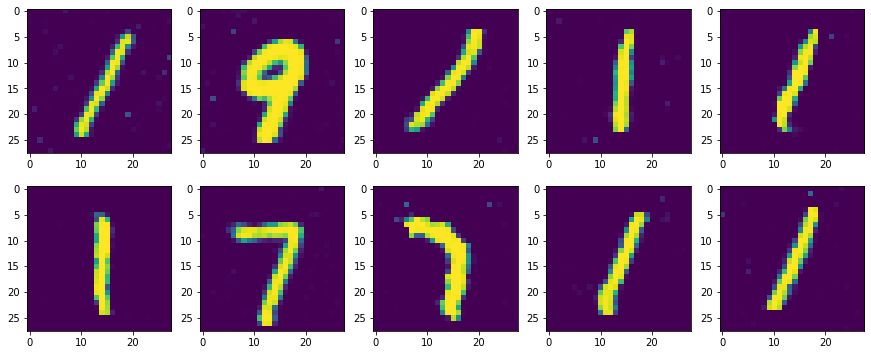

In [14]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

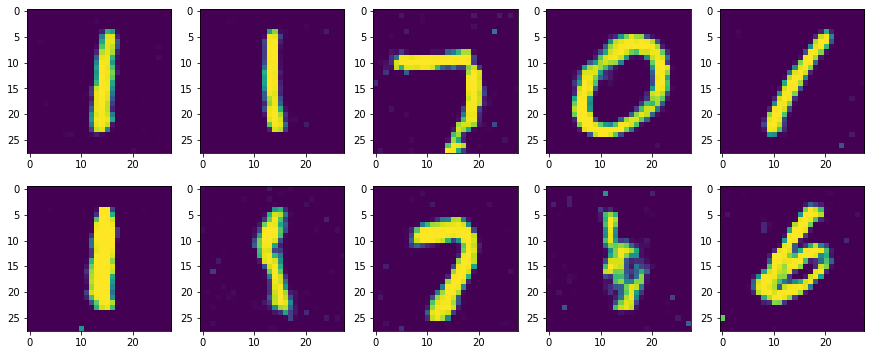

In [15]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

#### cGAN으로 MNIST 학습하기

In [16]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.176104545593262, D:0.009365929290652275
[1/1 EPOCHS, 199 ITER] G:5.778666019439697, D:0.010502871125936508
[1/1 EPOCHS, 299 ITER] G:1.4795494079589844, D:0.45556455850601196
[1/1 EPOCHS, 399 ITER] G:3.7900712490081787, D:0.08638172596693039


In [19]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 500
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/500 EPOCHS, 99 ITER] G:3.326474666595459, D:0.06792806833982468
[1/500 EPOCHS, 199 ITER] G:2.9420571327209473, D:0.09594608843326569
[1/500 EPOCHS, 299 ITER] G:3.8666188716888428, D:0.10184726119041443
[1/500 EPOCHS, 399 ITER] G:4.750511646270752, D:0.028145629912614822
[2/500 EPOCHS, 99 ITER] G:4.256070137023926, D:0.08118060231208801
[2/500 EPOCHS, 199 ITER] G:1.5025081634521484, D:0.8304798007011414
[2/500 EPOCHS, 299 ITER] G:3.410288095474243, D:0.11817006766796112
[2/500 EPOCHS, 399 ITER] G:0.9708210229873657, D:0.9334719181060791
[3/500 EPOCHS, 99 ITER] G:2.2075700759887695, D:0.2837490439414978
[3/500 EPOCHS, 199 ITER] G:1.974623680114746, D:0.3799228072166443
[3/500 EPOCHS, 299 ITER] G:2.4664180278778076, D:0.183403879404068
[3/500 EPOCHS, 399 ITER] G:2.4078593254089355, D:0.259520560503006
[4/500 EPOCHS, 99 ITER] G:2.8502585887908936, D:0.098206527531147
[4/500 EPOCHS, 199 ITER] G:3.401902675628662, D:0.060313545167446136
[4/500 EPOCHS, 299 ITER] G:3.563659429550171, D:0.09

[31/500 EPOCHS, 99 ITER] G:4.659901142120361, D:0.1578715443611145
[31/500 EPOCHS, 199 ITER] G:5.105116844177246, D:0.29534998536109924
[31/500 EPOCHS, 299 ITER] G:3.4275124073028564, D:0.18703331053256989
[31/500 EPOCHS, 399 ITER] G:3.6070556640625, D:0.24661186337471008
[32/500 EPOCHS, 99 ITER] G:4.576181411743164, D:0.11877280473709106
[32/500 EPOCHS, 199 ITER] G:5.015420436859131, D:0.07947887480258942
[32/500 EPOCHS, 299 ITER] G:4.56241512298584, D:0.24305009841918945
[32/500 EPOCHS, 399 ITER] G:4.600667476654053, D:0.10614209622144699
[33/500 EPOCHS, 99 ITER] G:4.350948810577393, D:0.2111300677061081
[33/500 EPOCHS, 199 ITER] G:3.372772216796875, D:0.1975494623184204
[33/500 EPOCHS, 299 ITER] G:4.548684120178223, D:0.16054534912109375
[33/500 EPOCHS, 399 ITER] G:4.736815452575684, D:0.179039865732193
[34/500 EPOCHS, 99 ITER] G:4.58940315246582, D:0.13809579610824585
[34/500 EPOCHS, 199 ITER] G:6.0891313552856445, D:0.18140465021133423
[34/500 EPOCHS, 299 ITER] G:5.253946304321289

[61/500 EPOCHS, 99 ITER] G:5.7514495849609375, D:0.17401665449142456
[61/500 EPOCHS, 199 ITER] G:5.298149585723877, D:0.21120454370975494
[61/500 EPOCHS, 299 ITER] G:4.866601943969727, D:0.29482555389404297
[61/500 EPOCHS, 399 ITER] G:5.532343864440918, D:0.24082641303539276
[62/500 EPOCHS, 99 ITER] G:5.382036209106445, D:0.21268977224826813
[62/500 EPOCHS, 199 ITER] G:5.1849212646484375, D:0.2144302874803543
[62/500 EPOCHS, 299 ITER] G:5.784443378448486, D:0.24929538369178772
[62/500 EPOCHS, 399 ITER] G:5.621797561645508, D:0.1507003903388977
[63/500 EPOCHS, 99 ITER] G:5.383062839508057, D:0.262275367975235
[63/500 EPOCHS, 199 ITER] G:5.472500324249268, D:0.2240368276834488
[63/500 EPOCHS, 299 ITER] G:4.986629486083984, D:0.19945602118968964
[63/500 EPOCHS, 399 ITER] G:5.6065144538879395, D:0.1632034182548523
[64/500 EPOCHS, 99 ITER] G:6.3770751953125, D:0.21166330575942993
[64/500 EPOCHS, 199 ITER] G:5.60542106628418, D:0.20442135632038116
[64/500 EPOCHS, 299 ITER] G:5.54690027236938

[91/500 EPOCHS, 99 ITER] G:5.897939205169678, D:0.14195948839187622
[91/500 EPOCHS, 199 ITER] G:5.97396993637085, D:0.16148997843265533
[91/500 EPOCHS, 299 ITER] G:6.593157768249512, D:0.163005530834198
[91/500 EPOCHS, 399 ITER] G:5.8414306640625, D:0.24468891322612762
[92/500 EPOCHS, 99 ITER] G:6.185152530670166, D:0.13915854692459106
[92/500 EPOCHS, 199 ITER] G:5.51062536239624, D:0.17329999804496765
[92/500 EPOCHS, 299 ITER] G:6.784750461578369, D:0.169582337141037
[92/500 EPOCHS, 399 ITER] G:6.413905143737793, D:0.2055567353963852
[93/500 EPOCHS, 99 ITER] G:6.347663879394531, D:0.15260452032089233
[93/500 EPOCHS, 199 ITER] G:6.760531425476074, D:0.17771373689174652
[93/500 EPOCHS, 299 ITER] G:6.724638938903809, D:0.21821990609169006
[93/500 EPOCHS, 399 ITER] G:6.678484916687012, D:0.1539117395877838
[94/500 EPOCHS, 99 ITER] G:5.8394269943237305, D:0.17655132710933685
[94/500 EPOCHS, 199 ITER] G:7.1572980880737305, D:0.14685718715190887
[94/500 EPOCHS, 299 ITER] G:6.238478660583496,

[120/500 EPOCHS, 399 ITER] G:6.907560348510742, D:0.1108473539352417
[121/500 EPOCHS, 99 ITER] G:8.342687606811523, D:0.17699500918388367
[121/500 EPOCHS, 199 ITER] G:7.601346015930176, D:0.1141040027141571
[121/500 EPOCHS, 299 ITER] G:7.283041477203369, D:0.17791366577148438
[121/500 EPOCHS, 399 ITER] G:7.4844584465026855, D:0.17795389890670776
[122/500 EPOCHS, 99 ITER] G:8.213034629821777, D:0.09283608198165894
[122/500 EPOCHS, 199 ITER] G:6.613576889038086, D:0.14595311880111694
[122/500 EPOCHS, 299 ITER] G:7.971462249755859, D:0.14857856929302216
[122/500 EPOCHS, 399 ITER] G:7.8775434494018555, D:0.1251981556415558
[123/500 EPOCHS, 99 ITER] G:7.904331684112549, D:0.09980320930480957
[123/500 EPOCHS, 199 ITER] G:7.932308197021484, D:0.10532889515161514
[123/500 EPOCHS, 299 ITER] G:8.861616134643555, D:0.114336758852005
[123/500 EPOCHS, 399 ITER] G:7.599576950073242, D:0.14235632121562958
[124/500 EPOCHS, 99 ITER] G:6.986856460571289, D:0.17370712757110596
[124/500 EPOCHS, 199 ITER] 

[150/500 EPOCHS, 199 ITER] G:7.877256393432617, D:0.10900313407182693
[150/500 EPOCHS, 299 ITER] G:7.661627769470215, D:0.10693158209323883
[150/500 EPOCHS, 399 ITER] G:8.842647552490234, D:0.06980539858341217
[151/500 EPOCHS, 99 ITER] G:8.104565620422363, D:0.15011383593082428
[151/500 EPOCHS, 199 ITER] G:8.474748611450195, D:0.07206196337938309
[151/500 EPOCHS, 299 ITER] G:8.553265571594238, D:0.0817139744758606
[151/500 EPOCHS, 399 ITER] G:8.973236083984375, D:0.1874866783618927
[152/500 EPOCHS, 99 ITER] G:7.715597152709961, D:0.08847064524888992
[152/500 EPOCHS, 199 ITER] G:8.670451164245605, D:0.07516621053218842
[152/500 EPOCHS, 299 ITER] G:8.811633110046387, D:0.1340421736240387
[152/500 EPOCHS, 399 ITER] G:8.818037033081055, D:0.10474133491516113
[153/500 EPOCHS, 99 ITER] G:7.770273685455322, D:0.13845403492450714
[153/500 EPOCHS, 199 ITER] G:8.752196311950684, D:0.08501279354095459
[153/500 EPOCHS, 299 ITER] G:7.994839668273926, D:0.1470041126012802
[153/500 EPOCHS, 399 ITER] 

[179/500 EPOCHS, 399 ITER] G:9.188325881958008, D:0.07977230846881866
[180/500 EPOCHS, 99 ITER] G:9.60050106048584, D:0.11203047633171082
[180/500 EPOCHS, 199 ITER] G:10.63614273071289, D:0.09976274520158768
[180/500 EPOCHS, 299 ITER] G:9.852666854858398, D:0.05413459986448288
[180/500 EPOCHS, 399 ITER] G:10.134464263916016, D:0.0864778682589531
[181/500 EPOCHS, 99 ITER] G:8.825837135314941, D:0.13847699761390686
[181/500 EPOCHS, 199 ITER] G:10.654319763183594, D:0.10461840033531189
[181/500 EPOCHS, 299 ITER] G:9.368674278259277, D:0.0712796151638031
[181/500 EPOCHS, 399 ITER] G:9.895709991455078, D:0.07646480202674866
[182/500 EPOCHS, 99 ITER] G:9.55493450164795, D:0.054071418941020966
[182/500 EPOCHS, 199 ITER] G:10.232253074645996, D:0.044262707233428955
[182/500 EPOCHS, 299 ITER] G:9.72273063659668, D:0.07698257267475128
[182/500 EPOCHS, 399 ITER] G:9.692463874816895, D:0.054879263043403625
[183/500 EPOCHS, 99 ITER] G:9.969705581665039, D:0.0607018768787384
[183/500 EPOCHS, 199 ITE

[209/500 EPOCHS, 99 ITER] G:11.163422584533691, D:0.059453073889017105
[209/500 EPOCHS, 199 ITER] G:11.585856437683105, D:0.03932296112179756
[209/500 EPOCHS, 299 ITER] G:11.826595306396484, D:0.060359012335538864
[209/500 EPOCHS, 399 ITER] G:11.663591384887695, D:0.05040840432047844
[210/500 EPOCHS, 99 ITER] G:9.838370323181152, D:0.08983180671930313
[210/500 EPOCHS, 199 ITER] G:11.80250072479248, D:0.055149391293525696
[210/500 EPOCHS, 299 ITER] G:10.463762283325195, D:0.0845712199807167
[210/500 EPOCHS, 399 ITER] G:11.881247520446777, D:0.08184216171503067
[211/500 EPOCHS, 99 ITER] G:10.40567398071289, D:0.03154737129807472
[211/500 EPOCHS, 199 ITER] G:10.89864730834961, D:0.12053097784519196
[211/500 EPOCHS, 299 ITER] G:10.817949295043945, D:0.14427372813224792
[211/500 EPOCHS, 399 ITER] G:10.179283142089844, D:0.04196327179670334
[212/500 EPOCHS, 99 ITER] G:10.530868530273438, D:0.11758106201887131
[212/500 EPOCHS, 199 ITER] G:12.49520492553711, D:0.06613634526729584
[212/500 EPOC

[238/500 EPOCHS, 199 ITER] G:11.753772735595703, D:0.11083076894283295
[238/500 EPOCHS, 299 ITER] G:12.147573471069336, D:0.04700615257024765
[238/500 EPOCHS, 399 ITER] G:12.640405654907227, D:0.09027675539255142
[239/500 EPOCHS, 99 ITER] G:11.88856315612793, D:0.025096328929066658
[239/500 EPOCHS, 199 ITER] G:10.738475799560547, D:0.10963927954435349
[239/500 EPOCHS, 299 ITER] G:13.231511116027832, D:0.04692590609192848
[239/500 EPOCHS, 399 ITER] G:12.436912536621094, D:0.05421249195933342
[240/500 EPOCHS, 99 ITER] G:12.364961624145508, D:0.0786372572183609
[240/500 EPOCHS, 199 ITER] G:13.010873794555664, D:0.02759438008069992
[240/500 EPOCHS, 299 ITER] G:12.68687915802002, D:0.02138885110616684
[240/500 EPOCHS, 399 ITER] G:13.059755325317383, D:0.04833381995558739
[241/500 EPOCHS, 99 ITER] G:11.445302963256836, D:0.052285563200712204
[241/500 EPOCHS, 199 ITER] G:12.008167266845703, D:0.046768128871917725
[241/500 EPOCHS, 299 ITER] G:11.888334274291992, D:0.1119309514760971
[241/500 E

[267/500 EPOCHS, 299 ITER] G:12.655328750610352, D:0.0326516330242157
[267/500 EPOCHS, 399 ITER] G:13.640461921691895, D:0.0726233646273613
[268/500 EPOCHS, 99 ITER] G:13.942328453063965, D:0.034622661769390106
[268/500 EPOCHS, 199 ITER] G:12.914580345153809, D:0.122392937541008
[268/500 EPOCHS, 299 ITER] G:12.481080055236816, D:0.05480639263987541
[268/500 EPOCHS, 399 ITER] G:13.36479377746582, D:0.051663439720869064
[269/500 EPOCHS, 99 ITER] G:13.737624168395996, D:0.0855809822678566
[269/500 EPOCHS, 199 ITER] G:13.221092224121094, D:0.0789913684129715
[269/500 EPOCHS, 299 ITER] G:14.211445808410645, D:0.030976438894867897
[269/500 EPOCHS, 399 ITER] G:12.52707290649414, D:0.044724754989147186
[270/500 EPOCHS, 99 ITER] G:12.021541595458984, D:0.036757610738277435
[270/500 EPOCHS, 199 ITER] G:13.84960651397705, D:0.08073583245277405
[270/500 EPOCHS, 299 ITER] G:11.25125503540039, D:0.03398513048887253
[270/500 EPOCHS, 399 ITER] G:12.779065132141113, D:0.06401808559894562
[271/500 EPOCH

[296/500 EPOCHS, 299 ITER] G:12.728597640991211, D:0.0653839111328125
[296/500 EPOCHS, 399 ITER] G:15.377128601074219, D:0.03969378024339676
[297/500 EPOCHS, 99 ITER] G:14.614347457885742, D:0.033084992319345474
[297/500 EPOCHS, 199 ITER] G:14.048575401306152, D:0.04152529686689377
[297/500 EPOCHS, 299 ITER] G:14.974781036376953, D:0.03359982371330261
[297/500 EPOCHS, 399 ITER] G:13.5649995803833, D:0.01572897471487522
[298/500 EPOCHS, 99 ITER] G:14.864463806152344, D:0.0723269060254097
[298/500 EPOCHS, 199 ITER] G:14.13502311706543, D:0.06652282178401947
[298/500 EPOCHS, 299 ITER] G:13.437572479248047, D:0.11342912167310715
[298/500 EPOCHS, 399 ITER] G:13.431805610656738, D:0.016414713114500046
[299/500 EPOCHS, 99 ITER] G:11.838203430175781, D:0.076356902718544
[299/500 EPOCHS, 199 ITER] G:13.88027286529541, D:0.07106979936361313
[299/500 EPOCHS, 299 ITER] G:13.456401824951172, D:0.03671557083725929
[299/500 EPOCHS, 399 ITER] G:13.877058029174805, D:0.03331396356225014
[300/500 EPOCHS

[325/500 EPOCHS, 299 ITER] G:13.475030899047852, D:0.039173536002635956
[325/500 EPOCHS, 399 ITER] G:11.616439819335938, D:0.059720076620578766
[326/500 EPOCHS, 99 ITER] G:13.972681045532227, D:0.06871439516544342
[326/500 EPOCHS, 199 ITER] G:15.850288391113281, D:0.042088523507118225
[326/500 EPOCHS, 299 ITER] G:13.069604873657227, D:0.025284331291913986
[326/500 EPOCHS, 399 ITER] G:14.743505477905273, D:0.0706321969628334
[327/500 EPOCHS, 99 ITER] G:14.612079620361328, D:0.02448192611336708
[327/500 EPOCHS, 199 ITER] G:13.654454231262207, D:0.023514781147241592
[327/500 EPOCHS, 299 ITER] G:15.467029571533203, D:0.03762655705213547
[327/500 EPOCHS, 399 ITER] G:14.13437557220459, D:0.04460488259792328
[328/500 EPOCHS, 99 ITER] G:13.635623931884766, D:0.044380806386470795
[328/500 EPOCHS, 199 ITER] G:16.38509178161621, D:0.06538540124893188
[328/500 EPOCHS, 299 ITER] G:13.666366577148438, D:0.1341261863708496
[328/500 EPOCHS, 399 ITER] G:14.035866737365723, D:0.024064546450972557
[329/5

[354/500 EPOCHS, 299 ITER] G:15.151837348937988, D:0.05060974508523941
[354/500 EPOCHS, 399 ITER] G:13.075247764587402, D:0.04596785455942154
[355/500 EPOCHS, 99 ITER] G:14.81258487701416, D:0.03642880171537399
[355/500 EPOCHS, 199 ITER] G:15.005361557006836, D:0.03196552023291588
[355/500 EPOCHS, 299 ITER] G:13.970559120178223, D:0.013143513351678848
[355/500 EPOCHS, 399 ITER] G:14.800203323364258, D:0.011338034644722939
[356/500 EPOCHS, 99 ITER] G:12.884876251220703, D:0.016773788258433342
[356/500 EPOCHS, 199 ITER] G:14.988962173461914, D:0.03887848183512688
[356/500 EPOCHS, 299 ITER] G:14.06721305847168, D:0.03715714439749718
[356/500 EPOCHS, 399 ITER] G:14.36830997467041, D:0.046208687126636505
[357/500 EPOCHS, 99 ITER] G:13.5445556640625, D:0.05172508955001831
[357/500 EPOCHS, 199 ITER] G:13.08902359008789, D:0.10910343378782272
[357/500 EPOCHS, 299 ITER] G:14.564209938049316, D:0.01904589682817459
[357/500 EPOCHS, 399 ITER] G:15.040482521057129, D:0.07393810153007507
[358/500 EP

[383/500 EPOCHS, 299 ITER] G:15.038628578186035, D:0.015681907534599304
[383/500 EPOCHS, 399 ITER] G:13.860548973083496, D:0.06946375966072083
[384/500 EPOCHS, 99 ITER] G:15.65192699432373, D:0.015085305087268353
[384/500 EPOCHS, 199 ITER] G:15.585674285888672, D:0.03583686798810959
[384/500 EPOCHS, 299 ITER] G:15.147893905639648, D:0.014438106678426266
[384/500 EPOCHS, 399 ITER] G:14.43820571899414, D:0.03891843929886818
[385/500 EPOCHS, 99 ITER] G:15.211280822753906, D:0.01187431626021862
[385/500 EPOCHS, 199 ITER] G:14.614973068237305, D:0.04314633458852768
[385/500 EPOCHS, 299 ITER] G:15.697383880615234, D:0.09197627007961273
[385/500 EPOCHS, 399 ITER] G:15.973488807678223, D:0.00818616896867752
[386/500 EPOCHS, 99 ITER] G:15.329789161682129, D:0.1054234653711319
[386/500 EPOCHS, 199 ITER] G:15.304734230041504, D:0.0724831372499466
[386/500 EPOCHS, 299 ITER] G:15.975462913513184, D:0.03540068119764328
[386/500 EPOCHS, 399 ITER] G:14.730131149291992, D:0.03324349969625473
[387/500 E

[412/500 EPOCHS, 299 ITER] G:17.375709533691406, D:0.033320143818855286
[412/500 EPOCHS, 399 ITER] G:16.17884635925293, D:0.031926341354846954
[413/500 EPOCHS, 99 ITER] G:16.726165771484375, D:0.02237522229552269
[413/500 EPOCHS, 199 ITER] G:14.250669479370117, D:0.051251381635665894
[413/500 EPOCHS, 299 ITER] G:17.635374069213867, D:0.03934388980269432
[413/500 EPOCHS, 399 ITER] G:14.883148193359375, D:0.04517355561256409
[414/500 EPOCHS, 99 ITER] G:15.867120742797852, D:0.009371412917971611
[414/500 EPOCHS, 199 ITER] G:15.225362777709961, D:0.008708225563168526
[414/500 EPOCHS, 299 ITER] G:17.463031768798828, D:0.02011706680059433
[414/500 EPOCHS, 399 ITER] G:16.40721893310547, D:0.013119321316480637
[415/500 EPOCHS, 99 ITER] G:16.823238372802734, D:0.016596117988228798
[415/500 EPOCHS, 199 ITER] G:16.009721755981445, D:0.03255105018615723
[415/500 EPOCHS, 299 ITER] G:16.490676879882812, D:0.012255408801138401
[415/500 EPOCHS, 399 ITER] G:15.912041664123535, D:0.030558284372091293
[4

[441/500 EPOCHS, 299 ITER] G:17.487253189086914, D:0.018493859097361565
[441/500 EPOCHS, 399 ITER] G:16.182832717895508, D:0.044799454510211945
[442/500 EPOCHS, 99 ITER] G:17.028614044189453, D:0.0035649570636451244
[442/500 EPOCHS, 199 ITER] G:16.969663619995117, D:0.009215469472110271
[442/500 EPOCHS, 299 ITER] G:17.241703033447266, D:0.01164907868951559
[442/500 EPOCHS, 399 ITER] G:14.979734420776367, D:0.04793646186590195
[443/500 EPOCHS, 99 ITER] G:16.741296768188477, D:0.014934048987925053
[443/500 EPOCHS, 199 ITER] G:17.264354705810547, D:0.04869859293103218
[443/500 EPOCHS, 299 ITER] G:17.882976531982422, D:0.02458219602704048
[443/500 EPOCHS, 399 ITER] G:13.771712303161621, D:0.01404002495110035
[444/500 EPOCHS, 99 ITER] G:17.46477508544922, D:0.011334476061165333
[444/500 EPOCHS, 199 ITER] G:14.672577857971191, D:0.13302749395370483
[444/500 EPOCHS, 299 ITER] G:18.112451553344727, D:0.012131895869970322
[444/500 EPOCHS, 399 ITER] G:14.713384628295898, D:0.037122610956430435
[

[470/500 EPOCHS, 299 ITER] G:18.884429931640625, D:0.015841934829950333
[470/500 EPOCHS, 399 ITER] G:17.08367156982422, D:0.006532172206789255
[471/500 EPOCHS, 99 ITER] G:17.999975204467773, D:0.023483648896217346
[471/500 EPOCHS, 199 ITER] G:17.769784927368164, D:0.057378966361284256
[471/500 EPOCHS, 299 ITER] G:16.182106018066406, D:0.00534116942435503
[471/500 EPOCHS, 399 ITER] G:15.040836334228516, D:0.00911855511367321
[472/500 EPOCHS, 99 ITER] G:15.318986892700195, D:0.015616662800312042
[472/500 EPOCHS, 199 ITER] G:15.846803665161133, D:0.061618875712156296
[472/500 EPOCHS, 299 ITER] G:17.976097106933594, D:0.019894875586032867
[472/500 EPOCHS, 399 ITER] G:18.005672454833984, D:0.01287363562732935
[473/500 EPOCHS, 99 ITER] G:17.319211959838867, D:0.009681161493062973
[473/500 EPOCHS, 199 ITER] G:17.466306686401367, D:0.036296553909778595
[473/500 EPOCHS, 299 ITER] G:16.7458438873291, D:0.05854149907827377
[473/500 EPOCHS, 399 ITER] G:16.920150756835938, D:0.013976138085126877
[4

[499/500 EPOCHS, 299 ITER] G:19.19816780090332, D:0.0075858463533222675
[499/500 EPOCHS, 399 ITER] G:16.555458068847656, D:0.06466583162546158
[500/500 EPOCHS, 99 ITER] G:18.22085952758789, D:0.005417558364570141
[500/500 EPOCHS, 199 ITER] G:16.423789978027344, D:0.013411990366876125
[500/500 EPOCHS, 299 ITER] G:19.81678009033203, D:0.017623528838157654
[500/500 EPOCHS, 399 ITER] G:16.94741439819336, D:0.0024914732202887535


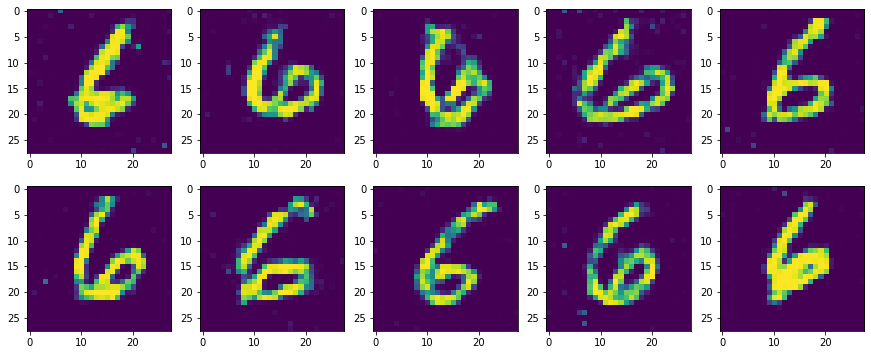

In [20]:
number = 6  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### (1) 데이터 준비하기

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
val = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


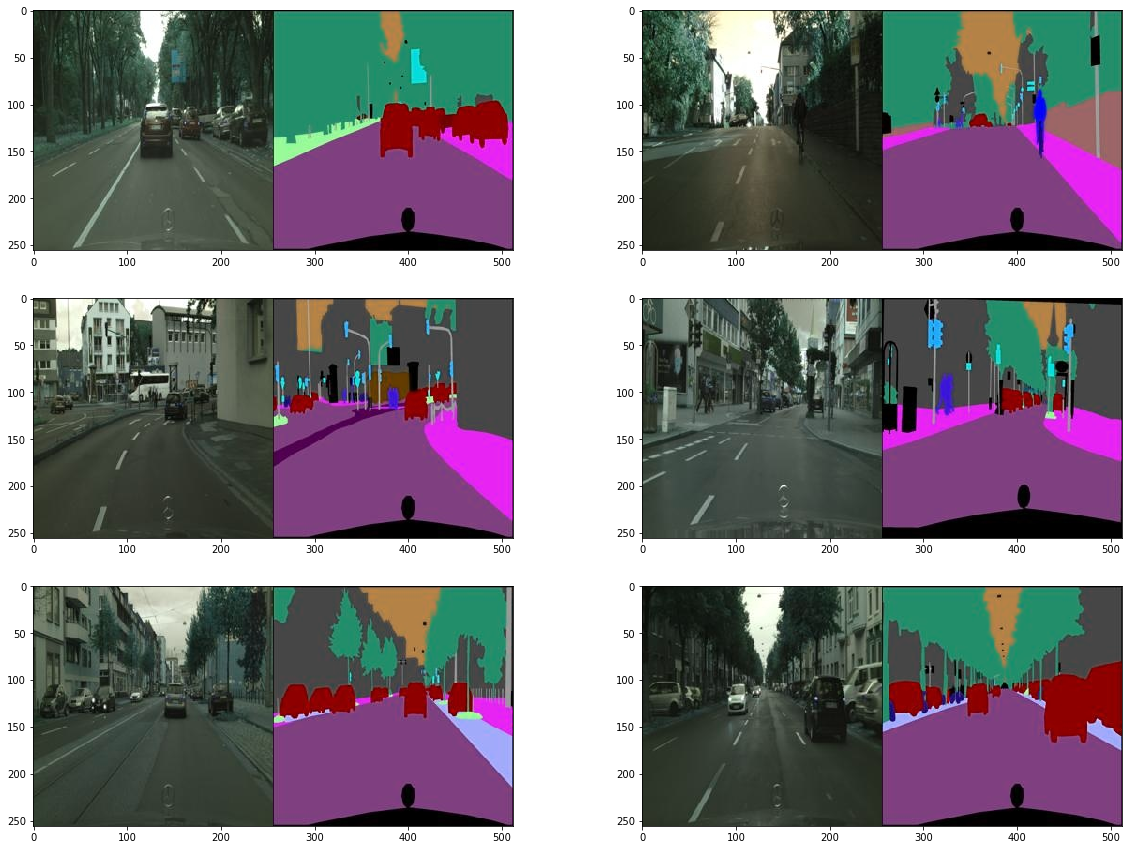

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


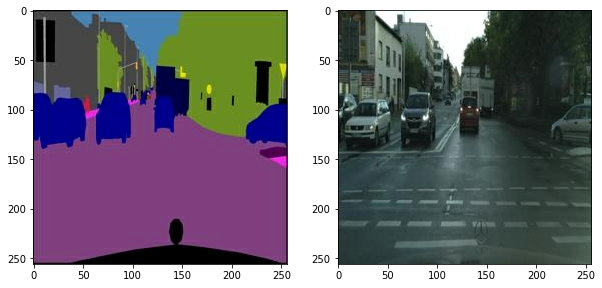

In [27]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [28]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


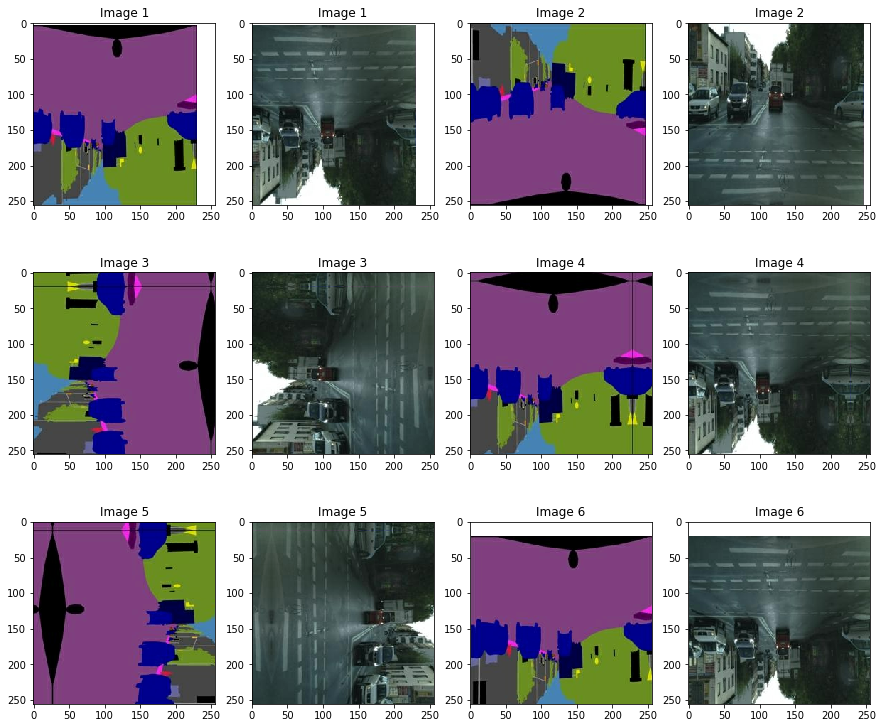

In [29]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

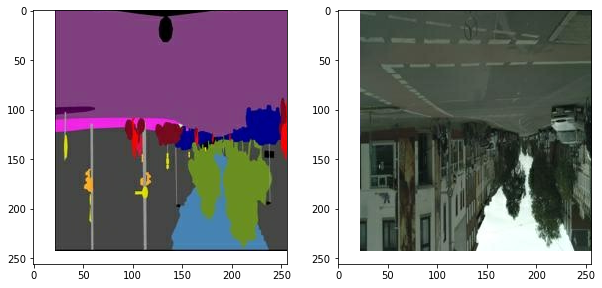

In [30]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 구현하기

In [31]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [32]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [33]:
Encoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

In [34]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [35]:
Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

In [36]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [37]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [38]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [39]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

### Discriminator 구현하기

In [40]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [41]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_115 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [42]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [43]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_17[0][0]      

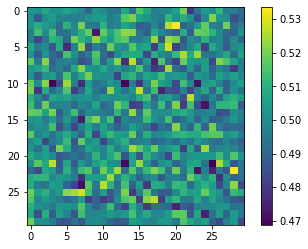

In [44]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 학습 및 테스트하기

In [45]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [46]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [47]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [48]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8576                     
L1_loss:0.3810                     
Discriminator_loss:1.3275

EPOCH[1] - STEP[20]                     
Generator_loss:0.9053                     
L1_loss:0.2362                     
Discriminator_loss:1.1181

EPOCH[1] - STEP[30]                     
Generator_loss:0.8381                     
L1_loss:0.2119                     
Discriminator_loss:1.2742

EPOCH[1] - STEP[40]                     
Generator_loss:0.9328                     
L1_loss:0.2086                     
Discriminator_loss:1.2805

EPOCH[1] - STEP[50]                     
Generator_loss:0.8573                     
L1_loss:0.1919                     
Discriminator_loss:1.2068

EPOCH[1] - STEP[60]                     
Generator_loss:0.9765                     
L1_loss:0.1898                     
Discriminator_loss:1.2394

EPOCH[1] - STEP[70]                     
Generator_loss:1.0654                     
L1_loss:0.1875                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.8024                     
L1_loss:0.1735                     
Discriminator_loss:2.3798

EPOCH[3] - STEP[80]                     
Generator_loss:1.7246                     
L1_loss:0.2051                     
Discriminator_loss:0.3194

EPOCH[3] - STEP[90]                     
Generator_loss:2.6327                     
L1_loss:0.1799                     
Discriminator_loss:0.8975

EPOCH[3] - STEP[100]                     
Generator_loss:1.6402                     
L1_loss:0.1614                     
Discriminator_loss:0.8169

EPOCH[3] - STEP[110]                     
Generator_loss:1.4151                     
L1_loss:0.1841                     
Discriminator_loss:0.8885

EPOCH[3] - STEP[120]                     
Generator_loss:1.6245                     
L1_loss:0.1934                     
Discriminator_loss:0.4739

EPOCH[3] - STEP[130]                     
Generator_loss:1.2142                     
L1_loss:0.1527                

EPOCH[5] - STEP[130]                     
Generator_loss:0.3294                     
L1_loss:0.2105                     
Discriminator_loss:1.6143

EPOCH[5] - STEP[140]                     
Generator_loss:1.3756                     
L1_loss:0.1807                     
Discriminator_loss:0.6765

EPOCH[5] - STEP[150]                     
Generator_loss:1.4943                     
L1_loss:0.1784                     
Discriminator_loss:0.4711

EPOCH[5] - STEP[160]                     
Generator_loss:0.7530                     
L1_loss:0.1908                     
Discriminator_loss:1.8113

EPOCH[5] - STEP[170]                     
Generator_loss:1.9165                     
L1_loss:0.2288                     
Discriminator_loss:0.2557

EPOCH[5] - STEP[180]                     
Generator_loss:2.1749                     
L1_loss:0.1536                     
Discriminator_loss:0.8634

EPOCH[5] - STEP[190]                     
Generator_loss:2.4978                     
L1_loss:0.1892             

EPOCH[7] - STEP[190]                     
Generator_loss:1.0745                     
L1_loss:0.2113                     
Discriminator_loss:0.5854

EPOCH[7] - STEP[200]                     
Generator_loss:1.3487                     
L1_loss:0.1861                     
Discriminator_loss:0.5026

EPOCH[7] - STEP[210]                     
Generator_loss:1.7363                     
L1_loss:0.2134                     
Discriminator_loss:0.2612

EPOCH[7] - STEP[220]                     
Generator_loss:1.3734                     
L1_loss:0.1836                     
Discriminator_loss:0.6374

EPOCH[7] - STEP[230]                     
Generator_loss:1.9851                     
L1_loss:0.1759                     
Discriminator_loss:0.7498

EPOCH[7] - STEP[240]                     
Generator_loss:0.7141                     
L1_loss:0.2129                     
Discriminator_loss:1.1566

EPOCH[7] - STEP[250]                     
Generator_loss:2.1317                     
L1_loss:0.1965             

EPOCH[9] - STEP[250]                     
Generator_loss:1.8667                     
L1_loss:0.1615                     
Discriminator_loss:0.4332

EPOCH[10] - STEP[10]                     
Generator_loss:2.0439                     
L1_loss:0.1895                     
Discriminator_loss:0.2896

EPOCH[10] - STEP[20]                     
Generator_loss:1.4773                     
L1_loss:0.1432                     
Discriminator_loss:1.3722

EPOCH[10] - STEP[30]                     
Generator_loss:0.9733                     
L1_loss:0.2002                     
Discriminator_loss:0.8085

EPOCH[10] - STEP[40]                     
Generator_loss:0.2992                     
L1_loss:0.1771                     
Discriminator_loss:1.8049

EPOCH[10] - STEP[50]                     
Generator_loss:1.8998                     
L1_loss:0.1898                     
Discriminator_loss:0.3099

EPOCH[10] - STEP[60]                     
Generator_loss:0.5992                     
L1_loss:0.1620             

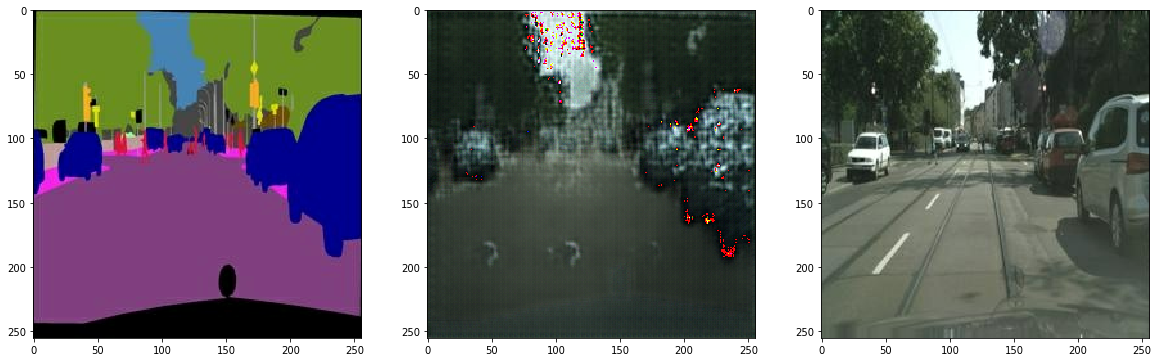

In [49]:
test_ind = 1

f = val + os.listdir(val)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## 회고

다른 분들과 결과물이 다르다.   
왜 그런지는 좀 알아봐야할 듯 하다.   
위에 숫자 생성 모델이서 신기했던 건, 정말 500epoch을 돌리니 훨씬 선명한 그림이 나왔다는 것이다.